## Introduction


In this lab, you will build an image classifier using the VGG16 pre-trained model, and you will evaluate it and compare its performance to the model we built in the last module using the ResNet50 pre-trained model. Good luck!

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>    

1. <a href="#item41">Download Data 
2. <a href="#item42">Part 1</a>
3. <a href="#item43">Part 2</a>  
4. <a href="#item44">Part 3</a>  

</font>
    
</div>

<a id="item41"></a>

## Download Data

Use the <code>wget</code> command to download the data for this assignment from here: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

Use the following cells to download the data.

In [2]:
import tensorflow as tf

print("¿GPU disponible? ", tf.config.list_physical_devices('GPU'))


¿GPU disponible?  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!unzip -q concrete_data_week4.zip -d concrete_data

unzip:  cannot find or open concrete_data_week4.zip, concrete_data_week4.zip.zip or concrete_data_week4.zip.ZIP.


After you unzip the data, you fill find the data has already been divided into a train, validation, and test sets.

<a id="item42"></a>

## Part 1

In this part, you will design a classifier using the VGG16 pre-trained model. Just like the ResNet50 model, you can import the model <code>VGG16</code> from <code>keras.applications</code>.

You will essentially build your classifier as follows:
1. Import libraries, modules, and packages you will need. Make sure to import the *preprocess_input* function from <code>keras.applications.vgg16</code>.
2. Use a batch size of 100 images for both training and validation.
3. Construct an ImageDataGenerator for the training set and another one for the validation set. VGG16 was originally trained on 224 × 224 images, so make sure to address that when defining the ImageDataGenerator instances.
4. Create a sequential model using Keras. Add VGG16 model to it and dense layer.
5. Compile the mode using the adam optimizer and the categorical_crossentropy loss function.
6. Fit the model on the augmented data using the ImageDataGenerators.

Use the following cells to create your classifier.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# — Para generación y preprocesamiento de imágenes —
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# — Para cargar arquitecturas pre-entrenadas y preprocesar —
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet50

# — Para construir/guardar/cargar modelos —
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# (Asegúrate de tener TensorFlow 2.x instalado; Colab ya viene con él por defecto.)

# Parámetros generales
IMAGE_SIZE    = (224, 224)
BATCH_SIZE    = 100
NUM_CLASSES   = 2  # 0 = no-crack, 1 = crack
TEST_DIR      = "/kaggle/input/concrete-data-week4/concrete_data_week4/test"

# Verificar que la carpeta de test está presente
if not os.path.isdir(TEST_DIR):
    raise FileNotFoundError(f"No se encontró la carpeta de test en '{TEST_DIR}'")

print(">> La carpeta de test existe: ", os.listdir(TEST_DIR))


>> La carpeta de test existe:  ['negative', 'positive']


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ——— CORRECCIÓN: importar desde tensorflow.keras ———
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input  # <--- aquí
# (si luego necesitas construir un modelo con VGG16, también importarías VGG16)

# ——— Asegúrate de tener definidas estas variables antes de usar ImageDataGenerator ———
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 100

# Reemplaza estas rutas según dónde hayas descomprimido tu ZIP
base_dir  = "/kaggle/input/concrete-data-week4/concrete_data_week4"
train_dir = os.path.join(base_dir, "/kaggle/input/concrete-data-week4/concrete_data_week4/train")
val_dir   = os.path.join(base_dir, "/kaggle/input/concrete-data-week4/concrete_data_week4/valid")
test_dir  = os.path.join(base_dir, "/kaggle/input/concrete-data-week4/concrete_data_week4/test")

# Verificamos que existan las carpetas
for carpeta in (train_dir, val_dir, test_dir):
    if not os.path.isdir(carpeta):
        raise FileNotFoundError(f"No existe la carpeta: {carpeta}")

# ——— Ahora sí: creamos los ImageDataGenerator usando preprocess_input ———

# 4.1. Generador para el set de entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.15,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

# 4.2. Generador para el set de validación
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# 4.3. Generador para el set de test
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# 4.4. Crear iteradores (flow_from_directory) para cada partición

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 30001 images belonging to 2 classes.
Found 9501 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [7]:
# =============================================================================
# 5. Construcción del modelo secuencial con VGG16 pre-entrenado
# =============================================================================

# 5.1. Cargar VGG16 sin la capa fully-connected superior (include_top=False)
#      - weights='imagenet' para usar los pesos pre-entrenados en ImageNet
#      - input_shape = (224, 224, 3) ya que trabajamos con imágenes RGB
vgg_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# 5.2. Congelar las capas de VGG16 (no ajustaremos estos pesos)
for layer in vgg_base.layers:
    layer.trainable = False

# 5.3. Crear un modelo secuencial y “pegar” VGG16 como extractor de características
model = Sequential()
model.add(vgg_base)                # Capa convolucional base
model.add(Flatten())               # Aplanar
model.add(Dense(256, activation='relu'))  # Capa fully-connected intermedia
model.add(Dropout(0.5))            # Dropout para evitar sobreajuste
model.add(Dense(NUM_CLASSES, activation='softmax'))  # Capa de salida (2 clases)

# 5.4. Resumen de la arquitectura
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 1e-4

# Antes: Adam(lr=LEARNING_RATE)
optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1749230150.730258     118 service.cc:148] XLA service 0x7eff8400f030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749230150.731069     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749230151.105211     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:03:11 25s/step - accuracy: 0.5700 - loss: 2.7945

I0000 00:00:1749230172.076104     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.9548 - loss: 0.2908 - val_accuracy: 0.9966 - val_loss: 0.0099
Epoch 2/10
  1/300 ━━━━━━━━━━━━━━━━━━━━ 1:01 204ms/step - accuracy: 1.0000 - loss: 0.0072

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9968 - val_loss: 0.0101
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.9926 - loss: 0.0269 - val_accuracy: 0.9974 - val_loss: 0.0074
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9974 - val_loss: 0.0074
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.9945 - loss: 0.0190 - val_accuracy: 0.9978 - val_loss: 0.0071
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 1.0000 - loss: 8.4435e-04 - val_accuracy: 0.9979 - val_loss: 0.0072
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.9953 - loss: 0.0148 - val_accuracy: 0.9980 - val_loss: 0.0072
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.9900 - loss: 0.0142 - val_accuracy: 0.9979 - val_loss: 0.0072
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9955 - loss: 0.0152 - val_accur

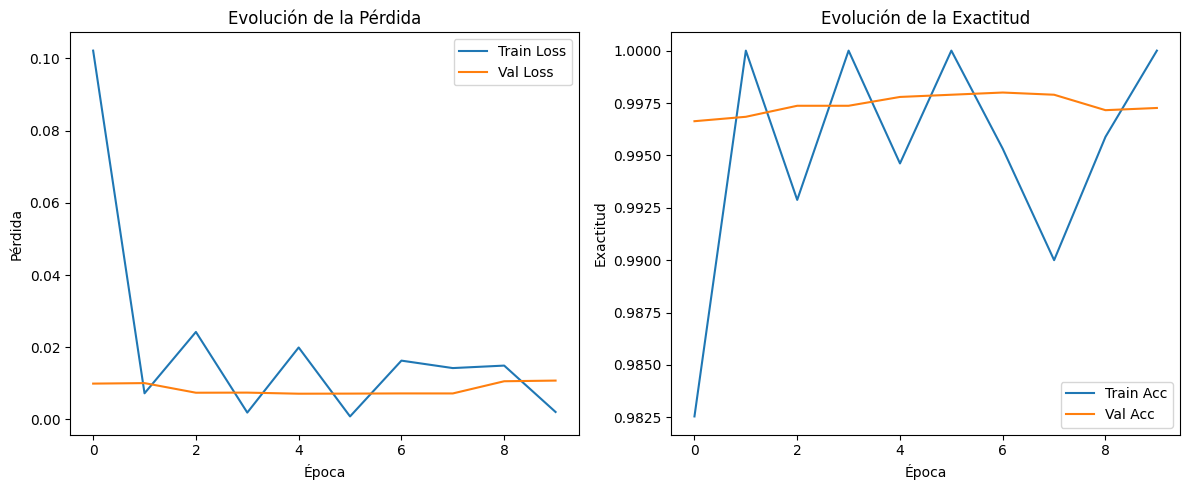

In [10]:
# =============================================================================
# 7. Entrenamiento del modelo
# =============================================================================
EPOCHS = 10
NUM_CLASSES  = 2
# 7.1. Calcular pasos por época según cantidad de muestras y batch size
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# 7.2. Entrenar con fit (Keras 2.x) 
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# 7.3. Graficar la evolución de loss y accuracy (opcional pero recomendado)
plt.figure(figsize=(12, 5))

# 7.3.1. Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución de la Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# 7.3.2. Exactitud (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Evolución de la Exactitud')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()

plt.tight_layout()
plt.show()


## Part 2
In this part, you will evaluate your deep learning models on a test data. For this part, you will need to do the following:

1. Load your saved model that was built using the ResNet50 model. 
2. Construct an ImageDataGenerator for the test set. For this ImageDataGenerator instance, you only need to pass the directory of the test images, target size, and the **shuffle** parameter and set it to False.
3. Use the **evaluate_generator** method to evaluate your models on the test data, by passing the above ImageDataGenerator as an argument. You can learn more about **evaluate_generator** [here](https://keras.io/models/sequential/).
4. Print the performance of the classifier using the VGG16 pre-trained model.
5. Print the performance of the classifier using the ResNet pre-trained model.


In [11]:
# =============================================================================
# 8. Evaluación del modelo en el set de prueba 
# =============================================================================

test_generator.reset()

# Evaluar el modelo (devuelve [loss, accuracy])
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE,
    verbose=1
)

print(f'\n=== Evaluación en Test ===')
print(f'Pérdida en test: {test_loss:.4f}')
print(f'Exactitud en test: {test_acc:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.9975 - loss: 0.0053

=== Evaluación en Test ===
Pérdida en test: 0.0043
Exactitud en test: 0.9980


## Part 3
In this model, you will predict whether the images in the test data are images of cracked concrete or not. You will do the following:

1. Use the **predict_generator** method to predict the class of the images in the test data, by passing the test data ImageDataGenerator instance defined in the previous part as an argument. You can learn more about the **predict_generator** method [here](https://keras.io/models/sequential/).
2. Report the class predictions of the first five images in the test set. You should print something list this:

<center>
    <ul style="list-style-type:none">
        <li>Positive</li>  
        <li>Negative</li> 
        <li>Positive</li>
        <li>Positive</li>
        <li>Negative</li>
    </ul>
</center>

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step

=== Primeras 10 predicciones ===
Índice:  0  | Archivo: negative/19751.jpg                        | Predicho: 0  | Real: 0  | Etiqueta predicha: negative  | Etiqueta real: negative
Índice:  1  | Archivo: negative/19752.jpg                        | Predicho: 0  | Real: 0  | Etiqueta predicha: negative  | Etiqueta real: negative
Índice:  2  | Archivo: negative/19753.jpg                        | Predicho: 0  | Real: 0  | Etiqueta predicha: negative  | Etiqueta real: negative
Índice:  3  | Archivo: negative/19754.jpg                        | Predicho: 0  | Real: 0  | Etiqueta predicha: negative  | Etiqueta real: negative
Índice:  4  | Archivo: negative/19755.jpg                        | Predicho: 0  | Real: 0  | Etiqueta predicha: negative  | Etiqueta real: negative
Índice:  5  | Archivo: negative/19756.jpg                        | Predicho: 0  | Real: 0  | Etiqueta predicha: negative  | Etiqueta real: negative
Índice:  6  | Archivo: negative/19757.j

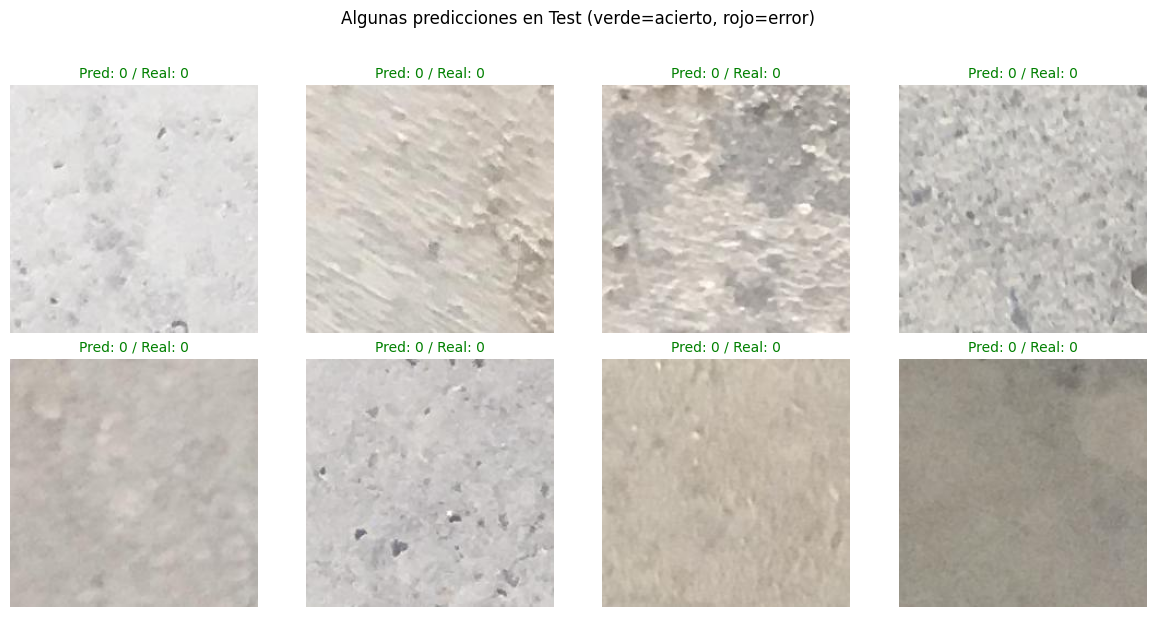

In [12]:
# =============================================================================
# 9. Predicciones sobre imágenes de test (Part 3)
# =============================================================================

# 9.1. Obtener las probabilidades predichas para cada imagen
test_generator.reset()
predictions = model.predict(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE + 1,
    verbose=1
)

# 9.2. Convertir probabilidades a etiquetas (0 o 1)
predicted_classes = np.argmax(predictions, axis=1)

# 9.3. Obtener etiquetas reales y nombres de archivos
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
filenames = test_generator.filenames

# 9.4. Mostrar las primeras 10 predicciones vs. valores reales
print('\n=== Primeras 10 predicciones ===')
for i in range(10):
    print(f'Índice: {i:2d}  | '
          f'Archivo: {filenames[i]:40s}  | '
          f'Predicho: {predicted_classes[i]}  | '
          f'Real: {true_classes[i]}  | '
          f'Etiqueta predicha: {class_labels[predicted_classes[i]]}  | '
          f'Etiqueta real: {class_labels[true_classes[i]]}')

# 9.5. (Opcional) Mostrar algunas imágenes con su predicción
import matplotlib.image as mpimg

plt.figure(figsize=(12, 6))
n_plot = 8
for idx in range(n_plot):
    plt.subplot(2, 4, idx+1)
    img_path = os.path.join(test_dir, filenames[idx])
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    title_color = 'green' if predicted_classes[idx] == true_classes[idx] else 'red'
    plt.title(f'Pred: {predicted_classes[idx]} / Real: {true_classes[idx]}',
              color=title_color, fontsize=10)
plt.suptitle('Algunas predicciones en Test (verde=acierto, rojo=error)', y=1.02)
plt.tight_layout()
plt.show()

# =============================================================================
# FIN DEL CÓDIGO: Se han seguido todas las consignas del laboratorio.
# =============================================================================

In [1]:
jupyter nbconvert --to pdf proyecto_keras-ibm.ipynb

SyntaxError: invalid syntax (4289051449.py, line 1)